In [ ]:
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
import os
import torch
from coati.common.util import batch_indexable
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from coati.models.regression.basic_due import basic_due
from coati.utils.chem import rm_radical, token_clean, rdkit_normal_smi

In [ ]:

def embed_and_score_in_batches_regression(
    records,
    encoder,
    tokenizer,
    batch_size=128,
    score=True,
    smiles_field="smiles",
):
    # A helper function to compute embeddings from the model encoder and
    # rdkit properties of molecules in batches. The input list of dict records
    # is modified in place.

    print("Embedding and scoring iterable from smiles.")
    batch_iter = batch_indexable(records, batch_size)
    num_batches = len(records) // batch_size
    with torch.no_grad():
        for i, batch in enumerate(batch_iter):
            print(f"batch: {i}/{num_batches}")
            try:
                batch_mols = [Chem.MolFromSmiles(row[smiles_field]) for row in batch]
                batch_smiles = [Chem.MolToSmiles(m) for m in batch_mols]
                batch_tokens = torch.tensor(
                    [
                        tokenizer.tokenize_text("[SMILES]" + s + "[STOP]", pad=True)
                        if s != "*"
                        else tokenizer.tokenize_text("[SMILES]C[STOP]", pad=True)
                        for s in batch_smiles
                    ],
                    device=encoder.device,
                    dtype=torch.int,
                )
                batch_embeds = encoder.encode_tokens(batch_tokens, tokenizer)
                if score:
                    batch_logp = [Chem.Crippen.MolLogP(m) for m in batch_mols]
                    batch_qed = [Chem.QED.qed(m) for m in batch_mols]
                if len(batch) < 2:
                    batch[0]["emb_smiles"] = batch_embeds[0].detach().cpu().numpy()
                    if score:
                        batch[0]["qed"] = batch_qed[0]
                        batch[0]["logp"] = batch_logp[0]
                        batch[0]["smiles"] = batch_smiles[0]
                else:
                    for k, r in enumerate(batch):
                        batch[k]["emb_smiles"] = batch_embeds[k].detach().cpu().numpy()
                        if score:
                            batch[k]["qed"] = batch_qed[k]
                            batch[k]["logp"] = batch_logp[k]
                            batch[k]["smiles"] = batch_smiles[k]
            except Exception as Ex:
                print(Ex)
                continue

def get_due_plot(due_result, y_field="qed", save_name="regression_plot.png"):
    """Plots the DUE model regressed results."""

    # xs are the true values, ys are the predicted values, dys are the errors.
    xs, ys, dys = due_result

    fig, ax = plt.subplots(figsize=(11, 6))
    n_to_plot = 30000
    ax.errorbar(
        (xs[:n_to_plot]),
        (ys[:n_to_plot]),
        yerr=dys[:n_to_plot],
        fmt="o",
        color="black",
        ecolor="lightgray",
        elinewidth=3,
        capsize=0,
    )
    plt.xlabel("True " + y_field)
    plt.ylabel("Regressed " + y_field)
    plt.savefig(save_name)


In [ ]:
import argparse
arg_parser = argparse.ArgumentParser()
arg_parser.add_argument('--mode', choices=['basic', 'near', 'regression', 'dynamics', 'BO'], \
    default='basic',help='Generation mode')
arg_parser.add_argument('--regression_y', choices=['qed', 'logp', 'pic50'], \
    default='qed',help='Regression target')
arg_parser.add_argument('--device', choices=['cuda:0', 'cpu'], \
    default='cuda:0',help='Device')
arg_parser.add_argument('--seed', type=int, default=2024) 
arg_parser.add_argument('--model', type=str, default = \
                'model_ckpts/ecloud_augmented_37.pkl')
arg_parser.add_argument('--dataset', type=str, default='ecloud_coati_demo.pt')
arg_parser.add_argument('--smiles', type=str, default='data/alk_1514.txt')
arg_parser.add_argument('--output', type=str, default='mols/0423_near_mol4_30.txt')
arg_parser.add_argument('--noise', type=float, default=0.3)
args = arg_parser.parse_args([])


args.regression_y = 'pic50'

In [ ]:
DEVICE = torch.device(args.device)
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    doc_url=args.model,
)


In [ ]:
args.smiles = './examples/conditions/target_ic50/pdbbind_4bel.txt'

prefix = args.smiles.split('/')[-1].split('.')[0]+'_'

with open(args.smiles) as f:
    pairs = [line.strip('\n').split(',') for line in f]
subset = []
for pair in pairs:
    smi = pair[0]
    smi = token_clean(smi, tokenizer)
    if smi == None:
        continue
    subset.append({"smiles": smi, "source": f"{prefix[:-1]}", "docking": float(pair[1])})
    
embed_and_score_in_batches_regression(subset, encoder, tokenizer)
subset = [r for r in subset if "emb_smiles" in r]

save_name = 'results/'+prefix+'data.pt'
torch.save(subset, save_name)

In [ ]:
from glob import glob
smis = glob('./examples/conditions/target_ic50/*.txt')

y_field = 'pic50'
for smi in smis:
    args.smiles = smi
    prefix = args.smiles.split('/')[-1].split('.')[0]+'_'

    with open(args.smiles) as f:
        pair = [line.strip('\n').split(',') for line in f]
    subset = [{"smiles": p[0], "source": f"{prefix[:-1]}", "pic50": float(p[1])} for p in pair]
    embed_and_score_in_batches_regression(subset, encoder, tokenizer)
    subset = [r for r in subset if "emb_smiles" in r]

    save_name = 'results/'+prefix+'data.pt'
    torch.save(subset, save_name)

In [ ]:
prefix = args.smiles.split('/')[-1].split('.')[0]+'_'
save_name = 'results/'+prefix+'data.pt'
torch.save(subset, save_name)

In [ ]:
subset = torch.load('./data/trained_diff_property_4w.pt')

In [ ]:
y_field = 'docking'
print('num after embed:', len(subset))
prefix = args.smiles.split('/')[-1].split('.')[0]+'_'
qsar_model, qsar_res = basic_due(
    subset,
    x_field="emb_smiles",
    y_field=y_field,
    save_as="results/"+prefix+"regression_"+y_field+".pkl",
    continue_training=True,
    steps=3e4,
    random_seed=args.seed
    )
qsar_model = qsar_model.to(DEVICE)

pdbbind_4bel_R2: 0.8322605427191337


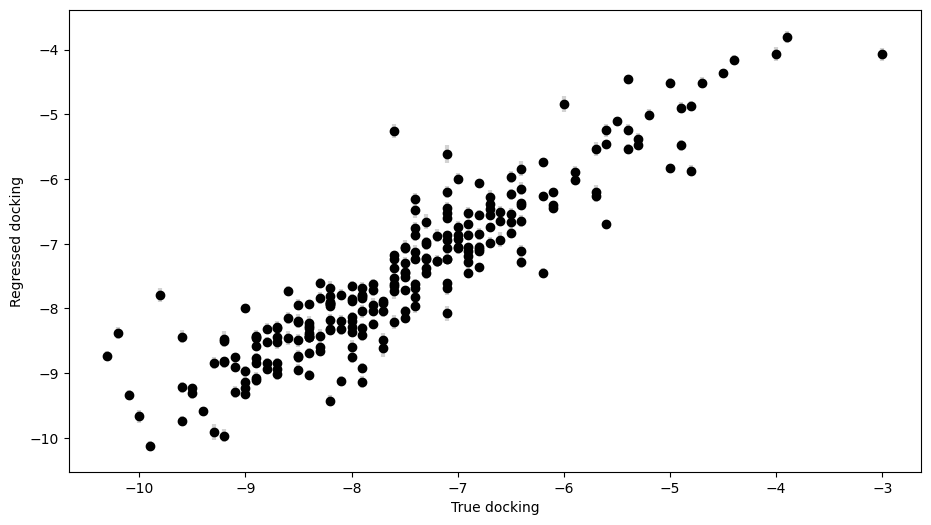

In [10]:
xs, ys, _ = qsar_res
print(prefix+'R2: '+str(r2_score(xs,ys)))
with open(f'results/{prefix}{y_field}_regression_result.csv','w') as f:
    f.write("True,Prediction\n")
    for i in range(len(xs)):
        f.write('%.3f,%.3f\n'%(xs[i], ys[i]))
get_due_plot(qsar_res, y_field=y_field, save_name="results/"+prefix+y_field+"_regression_plot.png")
